<a href="https://colab.research.google.com/github/sakuraszy/STATS-170A-Group/blob/add-license-1/models_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math

from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, explained_variance_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_predict
from math import sqrt
from math import inf
from math import log
from statistics import median, mean
from sklearn.model_selection import KFold

from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import RandomizedSearchCV

In [ ]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
data = pd.read_csv("https://raw.githubusercontent.com/sakuraszy/STATS-170A-Group/main/join_table.csv")
school = pd.read_csv("https://raw.githubusercontent.com/sakuraszy/STATS-170A-Group/main/Data_final/school_final.csv")
neighbor = pd.read_csv("https://raw.githubusercontent.com/sakuraszy/STATS-170A-Group/main/Data_in_process/neighbors_count.csv")
# data.sort_values(by=['price'], ascending=False, inplace = True)
data = data.select_dtypes(include='number')
data.insert(0, 'price', data.pop('price'))
data.dropna(inplace=True)
data.drop(columns=['population_rank', 'lot_size', 'housing_units', 'year_built'])

,price,zipcode,population,aland,median_household_income,average_household_income,per_capita_income,percent_of_households_with_incomes_200000_or_more,householder_under_25_years,householder_65_years_and_over,hhi_lt_25k,hhi_200k_or_more,race_and_ethnicity_total,population_density_sq_mi,median_age,educational_attainment_bachelors,educational_attainment_graduate,family_poverty_pct,unemployment_pct,median_value_of_owner_occupied_units,violent_crime_rate,property_crime_rate,postal_code,is_single_family,is_condo,is_multi_family,is_new_construction,beds,baths,baths_beds_ratio,garage,building_size
0,470000,90001,3966936,9071081,43360,54325,13727,0.007,41207,31250,3646,97,59832,17090.0,29.1,0.048,0.008,0.2329,0.087,359000,4.91,21.28,90001,1,0,0,0,3,1.5,0.5000,1,1030
1,400000,90001,3966936,9071081,43360,54325,13727,0.007,41207,31250,3646,97,59832,17090.0,29.1,0.048,0.008,0.2329,0.087,359000,4.91,21.28,90001,1,0,0,0,4,2.0,0.5000,0,1248
2,659000,90001,3966936,9071081,43360,54325,13727,0.007,41207,31250,3646,97,59832,17090.0,29.1,0.048,0.008,0.2329,0.087,359000,4.91,21.28,90001,0,1,0,0,5,2.0,0.4000,0,1897
3,477000,90001,3966936,9071081,43360,54325,13727,0.007,41207,31250,3646,97,59832,17090.0,29.1,0.048,0.008,0.2329,0.087,359000,4.91,21.28,90001,1,0,0,0,5,5.0,1.0000,0,2344
4,600000,90001,3966936,9071081,43360,54325,13727,0.007,41207,31250,3646,97,59832,17090.0,29.1,0.048,0.008,0.2329,0.087,359000,4.91,21.28,90001,0,0,1,0,8,4.0,0.5000,0,2616
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
81836,265000,96003,91580,615250582,53512,71816,30305,0.046,34669,43750,4434,844,44328,186.6,40.8,0.172,0.082,0.1121,0.050,262000,6.67,42.92,96003,0,1,0,0,2,3.0,1.5000,0,1502
81837,300000,96003,91580,615250582,53512,71816,30305,0.046,34669,43750,4434,844,44328,186.6,40.8,0.172,0.082,0.1121,0.050,262000,6.67,42.92,96003,1,0,0,0,3,2.5,0.8333,2,1687
81838,275000,96003,91580,615250582,53512,71816,30305,0.046,34669,43750,4434,844,44328,186.6,40.8,0.172,0.082,0.1121,0.050,262000,6.67,42.92,96003,1,0,0,0,3,2.5,0.8333,0,1430
81839,483500,96003,91580,615250582,53512,71816,30305,0.046,34669,43750,4434,844,44328,186.6,40.8,0.172,0.082,0.1121,0.050,262000,6.67,42.92,96003,1,0,0,0,3,2.0,0.6667,5,2552


In [ ]:
data = data[data['price'] <= 50000000]
data = data[data['price'] >= 100000]
##data['price'] = data['price'].apply(lambda x: round(log(x), 4))

In [ ]:
##data = data.groupby('zipcode')
##count = 0
##df = pd.DataFrame()
##for name, group in data:
##    truncate_num = int(len(group)*0.05)
##    truncate_len = len(group) - truncate_num
##    group.sort_values(by=['price'])
##    group.truncate(before = truncate_num, after = len(group) - truncate_num)
##    group = group.head(truncate_len)
##    truncate_len -= truncate_num
##    group = group.tail(truncate_len)
##    if(count == 0):
##        df = group
##        count += 1
##    else:
##        df = pd.concat([df, group])
##data.apply(lambda x:x.truncate(before=5, after=5))

In [ ]:
df = data
df

,price,zipcode,population,population_rank,aland,median_household_income,average_household_income,per_capita_income,percent_of_households_with_incomes_200000_or_more,householder_under_25_years,householder_65_years_and_over,hhi_lt_25k,hhi_200k_or_more,race_and_ethnicity_total,population_density_sq_mi,median_age,educational_attainment_bachelors,educational_attainment_graduate,family_poverty_pct,unemployment_pct,housing_units,median_value_of_owner_occupied_units,violent_crime_rate,property_crime_rate,postal_code,year_built,is_single_family,is_condo,is_multi_family,is_new_construction,beds,baths,baths_beds_ratio,garage,lot_size,building_size
0,470000,90001,3966936,1,9071081,43360,54325,13727,0.007,41207,31250,3646,97,59832,17090.0,29.1,0.048,0.008,0.2329,0.087,14174,359000,4.91,21.28,90001,1913,1,0,0,0,3,1.5,0.5000,1,5721,1030
1,400000,90001,3966936,1,9071081,43360,54325,13727,0.007,41207,31250,3646,97,59832,17090.0,29.1,0.048,0.008,0.2329,0.087,14174,359000,4.91,21.28,90001,1905,1,0,0,0,4,2.0,0.5000,0,5387,1248
2,659000,90001,3966936,1,9071081,43360,54325,13727,0.007,41207,31250,3646,97,59832,17090.0,29.1,0.048,0.008,0.2329,0.087,14174,359000,4.91,21.28,90001,1912,0,1,0,0,5,2.0,0.4000,0,5667,1897
3,477000,90001,3966936,1,9071081,43360,54325,13727,0.007,41207,31250,3646,97,59832,17090.0,29.1,0.048,0.008,0.2329,0.087,14174,359000,4.91,21.28,90001,1920,1,0,0,0,5,5.0,1.0000,0,6043,2344
4,600000,90001,3966936,1,9071081,43360,54325,13727,0.007,41207,31250,3646,97,59832,17090.0,29.1,0.048,0.008,0.2329,0.087,14174,359000,4.91,21.28,90001,1971,0,0,1,0,8,4.0,0.5000,0,4365,2616
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
81836,265000,96003,91580,84,615250582,53512,71816,30305,0.046,34669,43750,4434,844,44328,186.6,40.8,0.172,0.082,0.1121,0.050,19871,262000,6.67,42.92,96003,2003,0,1,0,0,2,3.0,1.5000,0,1742,1502
81837,300000,96003,91580,84,615250582,53512,71816,30305,0.046,34669,43750,4434,844,44328,186.6,40.8,0.172,0.082,0.1121,0.050,19871,262000,6.67,42.92,96003,2007,1,0,0,0,3,2.5,0.8333,2,13068,1687
81838,275000,96003,91580,84,615250582,53512,71816,30305,0.046,34669,43750,4434,844,44328,186.6,40.8,0.172,0.082,0.1121,0.050,19871,262000,6.67,42.92,96003,2006,1,0,0,0,3,2.5,0.8333,0,2614,1430
81839,483500,96003,91580,84,615250582,53512,71816,30305,0.046,34669,43750,4434,844,44328,186.6,40.8,0.172,0.082,0.1121,0.050,19871,262000,6.67,42.92,96003,1977,1,0,0,0,3,2.0,0.6667,5,89734,2552


In [ ]:
print(df['price'].mean())

793458.5061649319


In [ ]:
school = school.rename(columns={"zip": "zipcode"})
school


,zipcode,rank,rankOf,rankStars,rankStatewidePercentage,averageStandardScore,has_elementary,has_middle,has_high
0,90001,2499.60000,3770.00000,1.60000,32.66500,30.65371,1,1,1
1,90002,3507.25000,4490.75000,1.00000,22.12000,22.59365,1,1,1
2,90003,2792.88889,4293.44444,2.00000,40.26444,38.48460,1,1,1
3,90004,2183.62500,4875.00000,2.62500,55.11750,51.60555,1,0,1
4,90005,2005.37500,3649.50000,2.25000,45.96000,42.58934,1,1,1
...,...,...,...,...,...,...,...,...,...
807,96080,2262.00000,4910.71429,2.71429,56.06000,51.73835,1,1,0
808,96097,1199.66667,2327.00000,2.66667,48.25333,42.99176,1,1,1
809,96130,1985.20000,4443.00000,2.80000,54.47200,51.32287,1,1,1
810,96150,2374.57143,4305.28571,2.14286,44.20286,41.32167,1,1,1


In [ ]:
neighbor = neighbor.rename(columns={"zip_code": "zipcode"})
neighbor

,ocean_related,environment_related,building_related,community_related,positive_comments,more_rural,more_urban,other,zipcode
0,0,7,1,7,1,1,1,2,92173
1,2,96,5,161,29,26,43,16,92201
2,1,52,0,96,20,5,13,6,92203
3,0,9,0,12,3,3,13,0,94301
4,6,28,1,69,8,6,23,5,94303
...,...,...,...,...,...,...,...,...,...
666,0,28,0,51,1,11,28,1,92126
667,0,8,0,8,1,2,1,0,92139
668,1,8,0,8,5,1,7,0,90094
669,2,25,0,36,5,8,12,2,92154


In [ ]:
df = pd.merge(df, school, how = 'left', on = "zipcode", validate="many_to_one")
df = pd.merge(df, neighbor, how = 'left', on = "zipcode", validate="many_to_one")
df.set_index('zipcode', inplace=True)
df.fillna(0, inplace=True)
df

,price,population,population_rank,aland,median_household_income,average_household_income,per_capita_income,percent_of_households_with_incomes_200000_or_more,householder_under_25_years,householder_65_years_and_over,hhi_lt_25k,hhi_200k_or_more,race_and_ethnicity_total,population_density_sq_mi,median_age,educational_attainment_bachelors,educational_attainment_graduate,family_poverty_pct,unemployment_pct,housing_units,median_value_of_owner_occupied_units,violent_crime_rate,property_crime_rate,postal_code,year_built,is_single_family,is_condo,is_multi_family,is_new_construction,beds,baths,baths_beds_ratio,garage,lot_size,building_size,rank,rankOf,rankStars,rankStatewidePercentage,averageStandardScore,has_elementary,has_middle,has_high,ocean_related,environment_related,building_related,community_related,positive_comments,more_rural,more_urban,other
zipcode,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
90001,470000,3966936,1,9071081,43360,54325,13727,0.007,41207,31250,3646,97,59832,17090.0,29.1,0.048,0.008,0.2329,0.087,14174,359000,4.91,21.28,90001,1913,1,0,0,0,3,1.5,0.5000,1,5721,1030,2499.60,3770.0,1.6,32.6650,30.65371,1.0,1.0,1.0,0,9,2,15,2,5,13,4
90001,400000,3966936,1,9071081,43360,54325,13727,0.007,41207,31250,3646,97,59832,17090.0,29.1,0.048,0.008,0.2329,0.087,14174,359000,4.91,21.28,90001,1905,1,0,0,0,4,2.0,0.5000,0,5387,1248,2499.60,3770.0,1.6,32.6650,30.65371,1.0,1.0,1.0,0,9,2,15,2,5,13,4
90001,659000,3966936,1,9071081,43360,54325,13727,0.007,41207,31250,3646,97,59832,17090.0,29.1,0.048,0.008,0.2329,0.087,14174,359000,4.91,21.28,90001,1912,0,1,0,0,5,2.0,0.4000,0,5667,1897,2499.60,3770.0,1.6,32.6650,30.65371,1.0,1.0,1.0,0,9,2,15,2,5,13,4
90001,477000,3966936,1,9071081,43360,54325,13727,0.007,41207,31250,3646,97,59832,17090.0,29.1,0.048,0.008,0.2329,0.087,14174,359000,4.91,21.28,90001,1920,1,0,0,0,5,5.0,1.0000,0,6043,2344,2499.60,3770.0,1.6,32.6650,30.65371,1.0,1.0,1.0,0,9,2,15,2,5,13,4
90001,600000,3966936,1,9071081,43360,54325,13727,0.007,41207,31250,3646,97,59832,17090.0,29.1,0.048,0.008,0.2329,0.087,14174,359000,4.91,21.28,90001,1971,0,0,1,0,8,4.0,0.5000,0,4365,2616,2499.60,3770.0,1.6,32.6650,30.65371,1.0,1.0,1.0,0,9,2,15,2,5,13,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96003,265000,91580,84,615250582,53512,71816,30305,0.046,34669,43750,4434,844,44328,186.6,40.8,0.172,0.082,0.1121,0.050,19871,262000,6.67,42.92,96003,2003,0,1,0,0,2,3.0,1.5000,0,1742,1502,2053.25,5020.5,3.0,61.6675,58.80132,1.0,1.0,0.0,0,116,2,151,32,41,40,20
96003,300000,91580,84,615250582,53512,71816,30305,0.046,34669,43750,4434,844,44328,186.6,40.8,0.172,0.082,0.1121,0.050,19871,262000,6.67,42.92,96003,2007,1,0,0,0,3,2.5,0.8333,2,13068,1687,2053.25,5020.5,3.0,61.6675,58.80132,1.0,1.0,0.0,0,116,2,151,32,41,40,20
96003,275000,91580,84,615250582,53512,71816,30305,0.046,34669,43750,4434,844,44328,186.6,40.8,0.172,0.082,0.1121,0.050,19871,262000,6.67,42.92,96003,2006,1,0,0,0,3,2.5,0.8333,0,2614,1430,2053.25,5020.5,3.0,61.6675,58.80132,1.0,1.0,0.0,0,116,2,151,32,41,40,20


In [ ]:
# sample_df = df.sample(frac=0.01, random_state=1)

In [ ]:
# from google.colab import files
# sample_df.to_csv('sample_final.csv') 
# files.download('sample_final.csv')

In [ ]:
dc = round(df.corr(), 2)
##dc.drop([0:36])
dc.drop(dc.columns[0:35], axis = 1, inplace = True)
dc

,rank,rankOf,rankStars,rankStatewidePercentage,averageStandardScore,has_elementary,has_middle,has_high,ocean_related,environment_related,building_related,community_related,positive_comments,more_rural,more_urban,other
price,-0.30,-0.09,0.14,0.14,0.15,-0.11,-0.12,-0.18,0.13,-0.17,-0.02,-0.16,-0.09,-0.06,-0.04,-0.25
population,0.02,0.03,0.02,0.02,0.02,0.03,-0.02,-0.00,-0.10,-0.30,0.24,-0.24,-0.22,-0.16,0.06,-0.22
population_rank,-0.10,-0.01,0.08,0.08,0.08,-0.01,-0.02,-0.01,0.15,0.36,-0.05,0.32,0.35,0.32,0.15,0.25
aland,0.08,0.04,-0.03,-0.03,-0.04,0.03,0.04,0.02,-0.05,0.29,0.07,0.26,0.33,0.24,0.03,0.30
median_household_income,-0.58,-0.24,0.21,0.21,0.22,-0.25,-0.16,-0.25,0.03,0.03,-0.20,-0.01,0.04,0.06,-0.18,-0.21
average_household_income,-0.57,-0.23,0.22,0.21,0.22,-0.24,-0.18,-0.28,0.08,-0.04,-0.16,-0.06,0.03,0.03,-0.16,-0.23
per_capita_income,-0.52,-0.18,0.23,0.23,0.24,-0.21,-0.19,-0.29,0.13,-0.13,-0.11,-0.15,-0.02,-0.03,-0.11,-0.28
percent_of_households_with_incomes_200000_or_more,-0.55,-0.22,0.21,0.21,0.21,-0.24,-0.18,-0.26,0.07,-0.06,-0.14,-0.08,0.02,0.02,-0.15,-0.24
householder_under_25_years,-0.19,0.02,0.20,0.19,0.20,0.02,-0.02,-0.04,0.02,-0.03,-0.11,-0.06,-0.04,0.01,-0.06,-0.15
householder_65_years_and_over,-0.49,-0.18,0.20,0.20,0.20,-0.19,-0.10,-0.21,0.10,0.09,-0.18,0.05,0.12,0.10,-0.15,-0.11


[Text(0.5, 0, 'rank'),
 Text(1.5, 0, 'rankOf'),
 Text(2.5, 0, 'rankStars'),
 Text(3.5, 0, 'rankStatewidePercentage'),
 Text(4.5, 0, 'averageStandardScore'),
 Text(5.5, 0, 'has_elementary'),
 Text(6.5, 0, 'has_middle'),
 Text(7.5, 0, 'has_high'),
 Text(8.5, 0, 'ocean_related'),
 Text(9.5, 0, 'environment_related'),
 Text(10.5, 0, 'building_related'),
 Text(11.5, 0, 'community_related'),
 Text(12.5, 0, 'positive_comments'),
 Text(13.5, 0, 'more_rural'),
 Text(14.5, 0, 'more_urban'),
 Text(15.5, 0, 'other')]

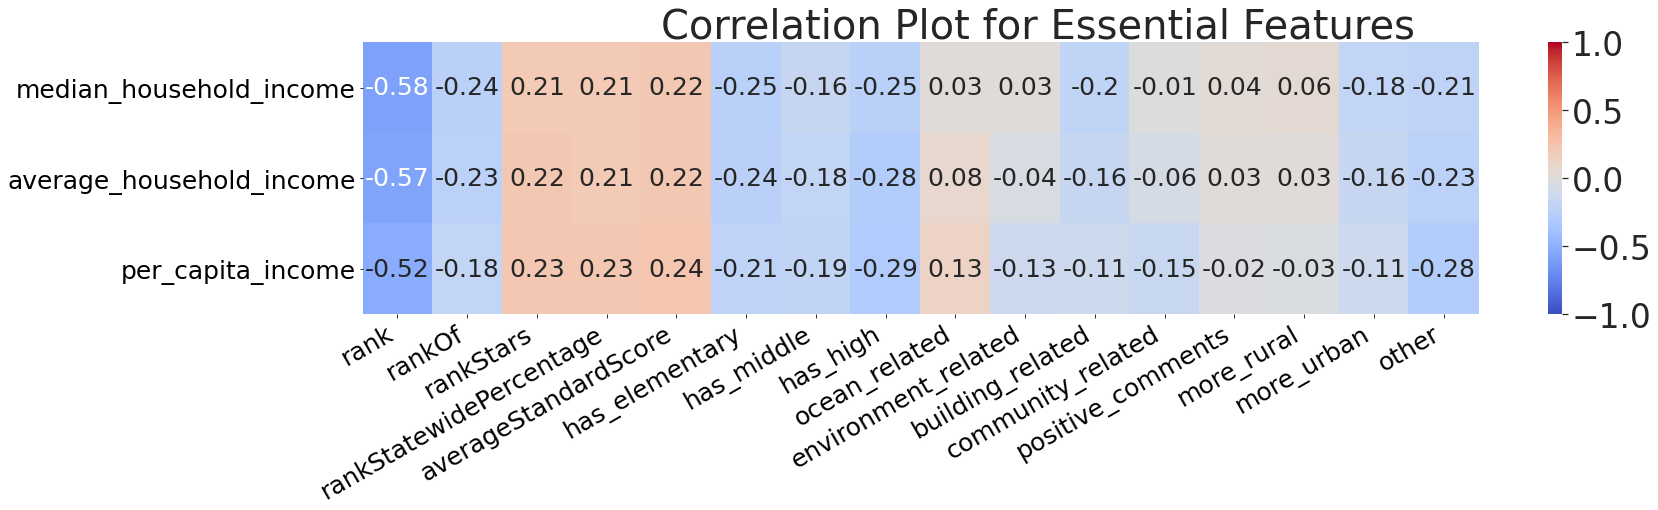

In [ ]:
fig, ax = plt.subplots(figsize=(25,5))
sns.set(font_scale=3)
sns.heatmap(dc[4:7], annot = True, 
            cmap=plt.get_cmap('coolwarm'), vmin = -1, vmax = 1, annot_kws={"fontsize":25}).figure.axes[-1].yaxis.label.set_size(450)
fig.suptitle('Correlation Plot for Essential Features', fontsize=40)
ax.set_yticklabels(ax.get_yticklabels(), fontsize = 25)
ax.set_xticklabels(ax.get_xticklabels(), rotation="30", horizontalalignment='right', fontsize = 25)

In [ ]:
X = df.iloc[:, 1:].values
y = df.iloc[:, 0].values

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, shuffle = True)
log_y_train = np.log(y_train)
log_y_test = np.log(y_test)
log_y = np.log(y)

In [ ]:
scaler = StandardScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
def inv_normalize_price(feature_normalized):
    mu = log_y.mean()
    sd = log_y.std()
    return sd*feature_normalized + mu

In [ ]:
print("Linear Regression\n")
regr = LinearRegression()
kfold = KFold(n_splits=5)
y_pred = cross_val_predict(regr, X, log_y, cv=kfold)
test_error = sqrt(mean_squared_error(y, np.exp(y_pred)))
print(test_error)
# scores = cross_validate(regr, X, y, cv=kfold,
#                         scoring=('r2', 'neg_root_mean_squared_error'),
#                         return_train_score=True)
# print('train rmse is: ' + str(-1*mean(scores['train_neg_root_mean_squared_error'])))
# print('test rmse is: ' + str(-1*mean(scores['test_neg_root_mean_squared_error'])))
# print('R-square is: ' + str(mean(scores['test_r2'])))
#regr.fit(X_train, log_y_train)
#print(regr.score(X_test, log_y_test))

Linear Regression

4976028.676029072


In [ ]:
#train_error = sqrt(mean_squared_error(y_train, np.exp(regr.predict(X_train))))
#print(train_error)

In [ ]:
#test_error = sqrt(mean_squared_error(y_test, np.exp(regr.predict(X_test))))
#print(test_error)

In [ ]:
# plt.figure(figsize=(15,10))
# plt.scatter(y_test, y_test-np.exp(regr.predict(X_test)))
# plt.title('Residuals VS Fitted Values', fontsize = 25)
# plt.xlabel('Fitted Values(Price in $)', fontsize = 20)
# plt.ylabel('Residuals', fontsize = 20)
# plt.ticklabel_format(useOffset=False, style='plain')
# plt.show()

In [ ]:
# lr_cv = LinearRegression()
# kfold = KFold(n_splits=5, shuffle = True)
# lr_cv_scores = cross_val_score(lr_cv, X, y, cv=kfold)
# print(lr_cv_scores)
# print('cv_scores mean {}'.format(np.mean(lr_cv_scores)))

In [ ]:
print("KNN\n")
neighbors = np.arange(1, 11)
train_rmse = np.empty(len(neighbors))
test_rmse = np.empty(len(neighbors))
r_square_list = np.empty(len(neighbors))
best_k = 0
best_difference = inf
  
with tf.device('/device:GPU:0'):
  for i, k in enumerate(neighbors):
      knn = KNeighborsRegressor(n_neighbors=k)
      kfold = KFold(n_splits=5, shuffle = True)
      scores = cross_validate(knn, X, y, cv=kfold,
                              scoring=('r2', 'neg_root_mean_squared_error'),
                              return_train_score=True)
      print(k)
      print('train rmse is: ' + str(-1*mean(scores['train_neg_root_mean_squared_error'])))
      train_rmse[i] = -1*mean(scores['train_neg_root_mean_squared_error'])
      print('test rmse is: ' + str(-1*mean(scores['test_neg_root_mean_squared_error'])))
      test_rmse[i] = -1*mean(scores['test_neg_root_mean_squared_error'])
      print('R-square is: ' + str(mean(scores['test_r2'])))
      r_square_list[i] = mean(scores['test_r2'])
      #knn.fit(X_train, y_train)
        
      # Compute traning and test data accuracy
#       train_pred = knn.predict(X_train)
#       test_pred = knn.predict(X_test)
#       train_error = sqrt(mean_squared_error(y_train, train_pred))
#       test_error = sqrt(mean_squared_error(y_test,test_pred))
#       for_test_error_hist = y_test-test_pred
#       print(np.median(for_test_error_hist))
#       print(max(for_test_error_hist))
#       if test_error-train_error < best_difference and test_error-train_error > 0:
#         best_difference = test_error-train_error
#         best_k = k
        
#         plt.figure(figsize=(15,15))
#         plt.hist(for_test_error_hist, range=[-800000 , 800000])
      
#       train_rmse[i] = train_error
#       test_rmse[i] = test_error
#       r_s = knn.score(X_test, y_test)
#       r_square_list[i] = r_s
#       print(k)
#       print('R-square is: ' + str(r_s))
#       print('Adjusted R-square is ' + str(1-(1-r_s)*(len(X_test)/(len(X_test)-30))))
#       print('Explained variance: ' + str(explained_variance_score(y_test, test_pred)))
#       print('train rmse is: ' + str(train_error))
#       print('test rmse is: ' + str(test_error))

# print("Best K is " + str(best_k))
    

KNN

1
train rmse is: 22905.002130574452
test rmse is: 317166.1585810671
R-square is: 0.7425153491153078
2
train rmse is: 159586.5937914257
test rmse is: 287342.3671136139
R-square is: 0.7881196036846787
3
train rmse is: 192927.21395890386
test rmse is: 284821.86593258946
R-square is: 0.7924587801052198
4
train rmse is: 212948.1680019579
test rmse is: 282163.1734713289
R-square is: 0.7961412966257121
5
train rmse is: 226675.47202673368
test rmse is: 280980.99698587164
R-square is: 0.797851471983462
6
train rmse is: 235762.82406481457
test rmse is: 284797.7891913701
R-square is: 0.7919403698316163
7
train rmse is: 243177.82824257007
test rmse is: 283833.80446386145
R-square is: 0.793706229930475
8
train rmse is: 249274.9905582277
test rmse is: 283073.3598380764
R-square is: 0.7948871723412707
9
train rmse is: 253802.5159198285
test rmse is: 285877.73006298015
R-square is: 0.7908987616520896
10
train rmse is: 258349.28951298035
test rmse is: 287745.92829713126
R-square is: 0.788317281853

In [ ]:
knn_cv = KNeighborsRegressor(n_neighbors=3)
kfold = KFold(n_splits=5, shuffle = True)
cv_scores = cross_val_score(knn_cv, X, y, cv=kfold)
print(cv_scores)
print('cv_scores mean{}'.format(np.mean(cv_scores)))

[0.7987351  0.74962347 0.78724936 0.7872073  0.8178178 ]
cv_scores mean0.788126605046307


In [ ]:
# X = df.iloc[:,lambda df: [4, 7]].values
# y = df.iloc[:, 0].values
# print(X)

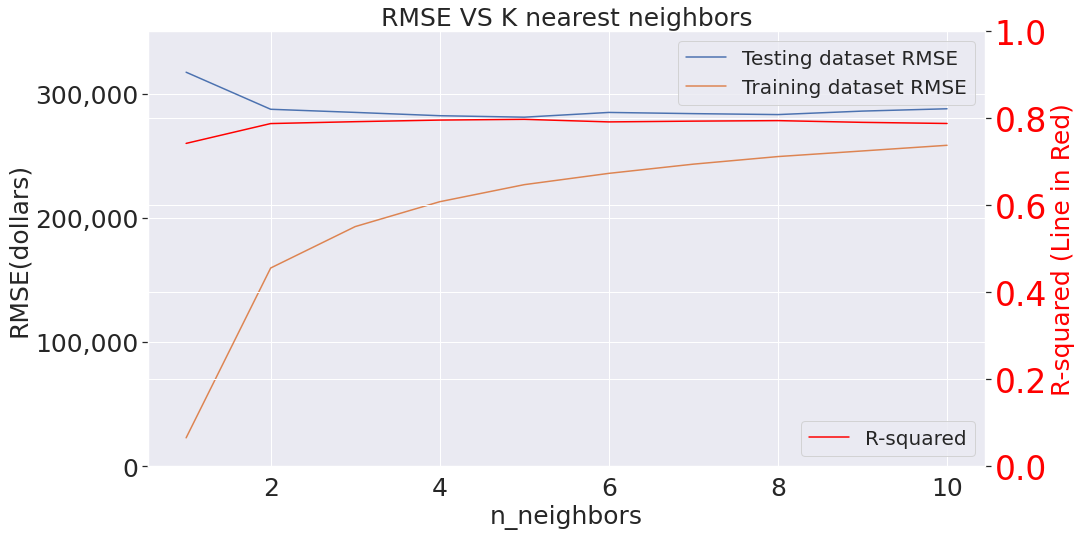

In [ ]:
fig, ax = plt.subplots(figsize=(15,8))
plt.plot(neighbors, test_rmse, label = 'Testing dataset RMSE')
plt.plot(neighbors, train_rmse, label = 'Training dataset RMSE')
plt.title('RMSE VS K nearest neighbors', fontsize = 25)
  
plt.legend(fontsize = 20)
plt.xlabel('n_neighbors', fontsize = 25)
plt.ylabel('RMSE(dollars)', fontsize = 25)
plt.xticks(fontsize = 25)
plt.ylim(-2, 350000)
ax.set_yticklabels(['-1', '0', '100,000', '200,000', '300,000'], fontsize = 25)
##plt.ticklabel_format(useOffset=False, style='plain')
ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('R-squared (Line in Red)', color = 'red', fontsize = 25)  # we already handled the x-label with ax1
ax2.plot(neighbors, r_square_list, color = 'red')
ax2.tick_params(axis='y', labelcolor = 'red')
ax2.set_ylim(0,1)
ax2.legend(["R-squared"],loc=4,fontsize = 20)
plt.show()

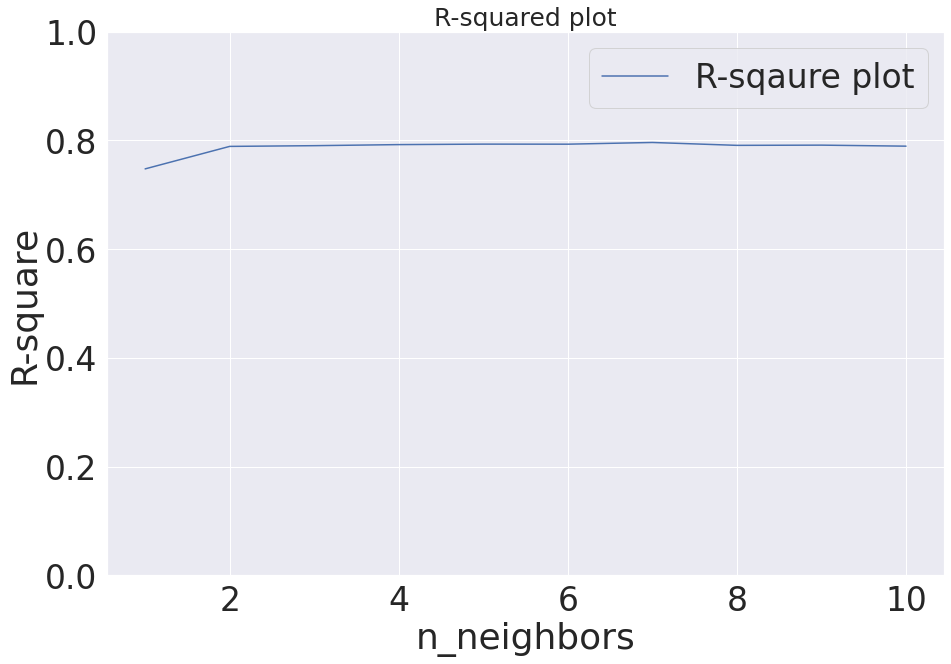

In [ ]:
plt.figure(figsize=(15,10))
plt.plot(neighbors, r_square_list, label = 'R-sqaure plot')
plt.title('R-squared plot', fontsize = 25)
  
plt.legend()
plt.ylim(0,1)
plt.xlabel('n_neighbors')
plt.ylabel('R-square')
plt.show()

In [ ]:
rf = RandomForestRegressor(n_estimators = 50, bootstrap=True, max_depth=80, min_samples_leaf=2, min_samples_split=5)
rf.fit(X_train, y_train)



RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=80, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=2,
                      min_samples_split=5, min_weight_fraction_leaf=0.0,
                      n_estimators=50, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

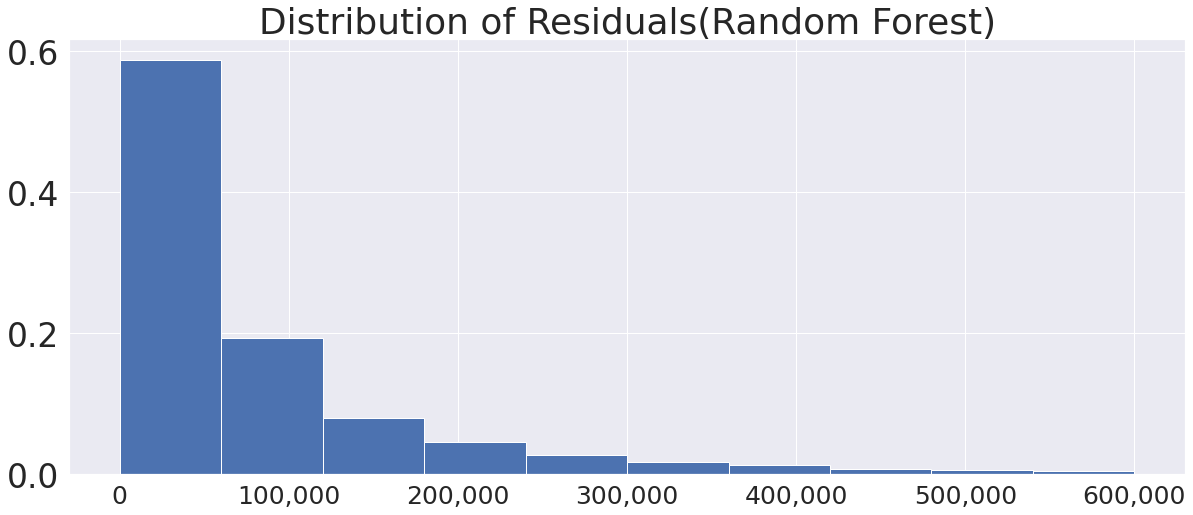

In [ ]:
for_his = np.absolute(y_test - rf.predict(X_test))
fig, ax = plt.subplots(figsize=(20,8))
plt.title('Distribution of Residuals(Random Forest)')
plt.hist(for_his, range = [0, 600000], weights=np.ones(len(for_his)) / len(for_his))
ax.set_xticklabels([ '-1', '0', '100,000', '200,000', '300,000', '400,000', '500,000', '600,000'], fontsize = 25)
plt.show()

In [ ]:
print("Random Forest\n")
rf_n = [1, 10, 20, 50, 100]
rf_train_rmse = []
rf_test_rmse = []
rf_r_squared = []
best_n = 0
best_test_rmse = inf

with tf.device('/device:GPU:0'):
  for n in rf_n:
    rf = RandomForestRegressor(n_estimators = n)
    kfold = KFold(n_splits=5, shuffle = True)
    scores = cross_validate(rf, X, y, cv=kfold,
                              scoring=('r2', 'neg_root_mean_squared_error'),
                              return_train_score=True)
    print(n)
    print('train rmse is: ' + str(-1*mean(scores['train_neg_root_mean_squared_error'])))
    rf_train_rmse.append(-1*mean(scores['train_neg_root_mean_squared_error']))
    print('test rmse is: ' + str(-1*mean(scores['test_neg_root_mean_squared_error'])))
    rf_test_rmse.append(-1*mean(scores['test_neg_root_mean_squared_error']))
    print('R-square is: ' + str(mean(scores['test_r2'])))
    rf_r_squared.append(mean(scores['test_r2']))
    if(-1*mean(scores['test_neg_root_mean_squared_error']) < best_test_rmse):
      best_test_rmse = -1*mean(scores['test_neg_root_mean_squared_error'])
      best_n = n
    # r_square_list[i] = mean(scores['test_r2'])
    # rf.fit(X_train, y_train)
    # print("Score for " + str(n) + " is: " + str(rf.score(X_test, y_test)))
    # train_error = sqrt(mean_squared_error(y_train, rf.predict(X_train)))
    # rf_train_rmse.append(train_error)
    # print("Training error for " + str(n) + " is: " + str(train_error))
    # test_error = sqrt(mean_squared_error(y_test, rf.predict(X_test)))
    # rf_test_rmse.append(test_error)
    # print("Testing error for " + str(n) + " is: " + str(test_error))






Random Forest

1
train rmse is: 185902.92926473057
test rmse is: 309529.8416233206
R-square is: 0.7539910934271808
10
train rmse is: 96234.17105146166
test rmse is: 221350.25876809013
R-square is: 0.874689921951761
20
train rmse is: 87623.06120987223
test rmse is: 217821.76790332724
R-square is: 0.8787405794230952
50
train rmse is: 82575.17006629039
test rmse is: 212822.44038804853
R-square is: 0.884088972222937
100
train rmse is: 80987.75494131773
test rmse is: 211743.93776801313
R-square is: 0.8853977485003959


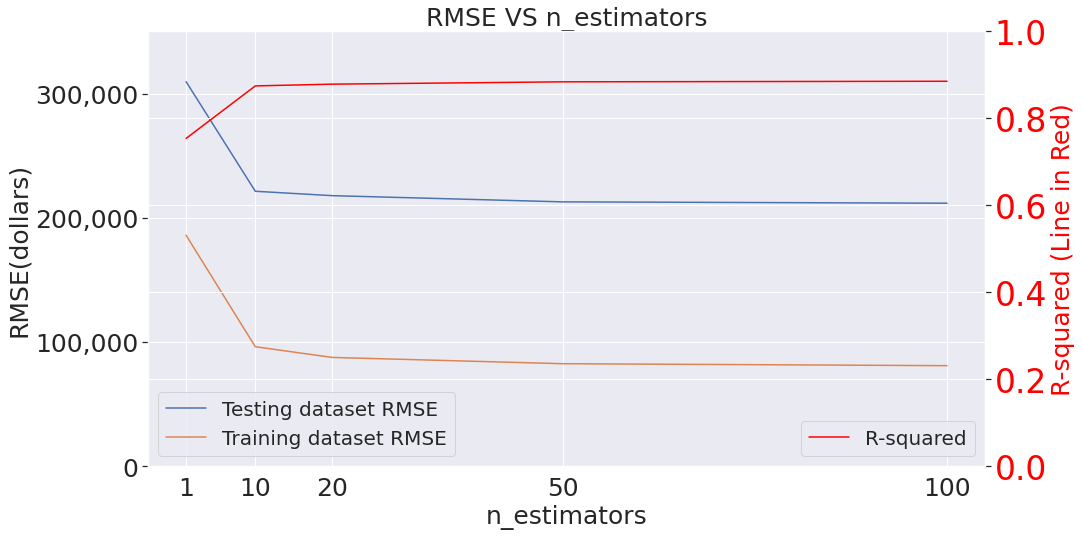

In [ ]:
fig, ax = plt.subplots(figsize=(15,8))
plt.plot(rf_n, rf_test_rmse, label = 'Testing dataset RMSE')
plt.plot(rf_n, rf_train_rmse, label = 'Training dataset RMSE')
plt.title('RMSE VS n_estimators', fontsize = 25)
  
plt.legend(fontsize = 20,loc=3)
plt.xlabel('n_estimators', fontsize = 25)
plt.ylabel('RMSE(dollars)', fontsize = 25)
plt.ylim(0, 350000)
plt.xticks([1, 10, 20, 50, 100], fontsize = 25)
##plt.yticks([200000, 400000, 600000, 800000, 1000000, 1200000], fontsize = 18)
ax.set_yticklabels(['0', '100,000',  '200,000', '300,000'], fontsize = 25)
##plt.ticklabel_format(useOffset=False, style='plain')

ax2 = ax.twinx()
ax2.set_ylabel('R-squared (Line in Red)', color = 'red', fontsize = 25)  # we already handled the x-label with ax1
ax2.plot(rf_n, rf_r_squared, color = 'red')
ax2.tick_params(axis='y', labelcolor = 'red')
ax2.set_ylim(0,1)
ax2.legend(["R-squared"],loc=4,fontsize = 20)
plt.show()

In [ ]:
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]

random_grid = {'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

rf = RandomForestRegressor(n_estimators=50)
rf_best = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 30, cv = 5, verbose=2, random_state=42, n_jobs = -1)
rf_best.fit(X_train, y_train)
print("Score is: " + str(rf_best.score(X_test, y_test)))
train_error = sqrt(mean_squared_error(y_train, rf_best.predict(X_train)))
##rf_train_rmse.append(train_error)
print("Training error is: " + str(train_error))
test_error = sqrt(mean_squared_error(y_test, rf_best.predict(X_test)))
##rf_test_rmse.append(test_error)
print("Testing error for is: " + str(test_error))

In [ ]:
rf_best.best_params_

In [ ]:
rf = RandomForestRegressor(n_estimators = 50, bootstrap=rf_best.best_params_['bootstrap'], max_depth=rf_best.best_params_['max_depth'], min_samples_leaf=rf_best.best_params_['min_samples_leaf'], min_samples_split=rf_best.best_params_['min_samples_split'])
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)



In [ ]:
pd.DataFrame({'Variable':df.iloc[:, 1:].columns,
              'Importance':rf.feature_importances_}).sort_values('Importance', ascending=False)

In [ ]:
# rf = RandomForestRegressor(n_estimators = 50)
# rf.fit(X_train, y_train)
# y_pred = rf.predict(X_test)



In [ ]:
# plt.figure(figsize=(15,10))
# plt.scatter(y_pred, y_test-y_pred)
# plt.title('Residuals VS Fitted Values', fontsize = 25)
# plt.xlabel('Fitted Values(Price in $)', fontsize = 20)
# plt.ylabel('Residuals', fontsize = 20)
# plt.xlim(0, 10000000)
# plt.ylim(-5000000, 5000000)
# plt.ticklabel_format(useOffset=False, style='plain')
# plt.show()

In [ ]:
# rf_cv = RandomForestRegressor(n_estimators = 20)
# kfold = KFold(n_splits=5, shuffle = True)
# rf_cv_scores = cross_val_score(rf_cv, X, y, cv=kfold)
# print(rf_cv_scores)
# print('cv_scores mean{}'.format(np.mean(rf_cv_scores)))

In [ ]:
print('\n')
print('ANN')
test_errors=[]
with tf.device('/device:GPU:0'):
  for layers in [50,60,70]:
    NNregr=MLPRegressor(hidden_layer_sizes=(layers, 7), max_iter=1000)
    NNregr.n_layers_=7
    NNregr.fit(X_train, y_train)
    train_error = sqrt(mean_squared_error(y_train, NNregr.predict(X_train)))
    print('\n')
    print("Hidden layers for " + str(layers) + " is: " + str(NNregr.n_layers_))
    print("Training error for " + str(layers) + " is: " + str(train_error))
    test_error = sqrt(mean_squared_error(y_test, NNregr.predict(X_test)))
    test_errors.append(test_error)
    print("Testing error for " + str(layers) + " is: " + str(test_error))
    score = NNregr.score(X_test, y_test)
    print("Score for " + str(layers) + " is: " + str(score))

In [ ]:
test_errors

In [ ]:
# from keras.models import Sequential
# from keras.layers import Dense
# from keras.wrappers.scikit_learn import KerasRegressor
# from sklearn.model_selection import cross_val_score
# from sklearn.model_selection import KFold
# #load dataset
# #split into input (X) and output (Y) variables
# #define base model
# #def baseline_model():
# # create model
# model = Sequential()
# model.add(Dense(50, input_dim=50, kernel_initializer='normal', activation='relu'))
# model.add(Dense(25, input_dim=50, kernel_initializer='normal', activation='relu'))
# model.add(Dense(1, kernel_initializer='normal'))
# # Compile model
# model.compile(loss='mean_squared_error', optimizer='adam')
# #return model
# #evaluate model
# #estimator = KerasRegressor(build_fn=baseline_model, epochs=100, batch_size=5, verbose=0)
# with tf.device('/device:GPU:0'):
#   model.fit(X_train, y_train, epochs=50, batch_size=5)
# test_error = sqrt(mean_squared_error(y_test, model.predict(X_test)))
# print(test_error)
# #kfold = KFold(n_splits=10)
# #results = cross_val_score(estimator, X_train, y_train, cv=kfold)
# #print("Baseline: %.2f (%.2f) MSE" % (results.mean(), results.std()))